In [1]:
%config Completer.use_jedi = False

from utils import *
from parallel import to_run, findpos, find_sigma_e

import numpy as np
import pandas as pd
import pickle
from matplotlib import pyplot as plt
import importlib
from multiprocessing import Pool
from tqdm.notebook import tqdm


from ising_model import SimulateMH

from scipy import signal

In [2]:
plt.rcParams["figure.facecolor"] = "white"
plt.rcParams["figure.dpi"] = 80
plt.rcParams["figure.figsize"] = [12,8]

In [3]:
pool = Pool(2)

In [4]:
with open("heat-capac-4-44-help.pkl", "rb")as ff:
    NtoT = pickle.load(ff)

In [5]:
Ns = [2]
n = Ns[0]
eps = 0.004
while n < max(NtoT.keys()):
    if abs(NtoT[n] - NtoT[Ns[-1]]) > eps:
        Ns.append(n)
    n+=1

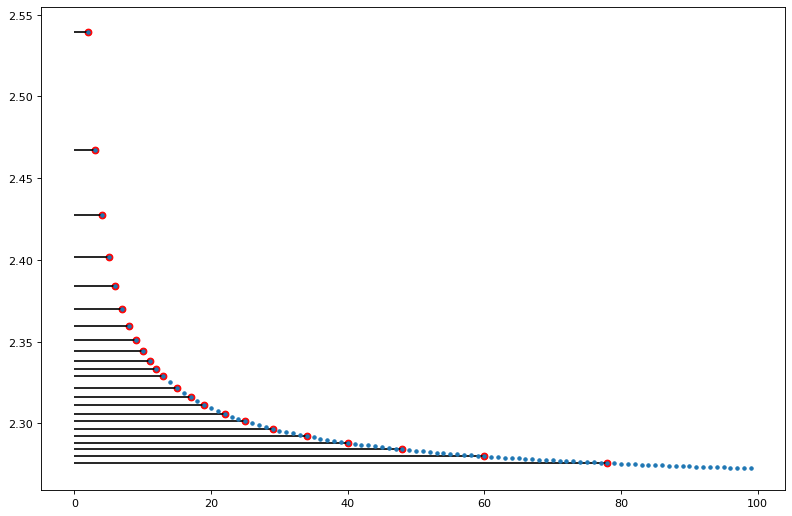

In [6]:
plt.plot(list(NtoT.keys()), list(NtoT.values()), ".")

for n in Ns:
    plt.scatter(n, NtoT[n], c="r")
    plt.hlines(y = NtoT[n], xmin=0, xmax=n)


In [ ]:
results = []
for N in Ns:
    TcN = NtoT[N]
    Ts = np.linspace(TcN-0.06, TcN+0.06, 128)
    for Ts1 in tqdm(Ts.reshape(16, 8)):
        runs = len(Ts1)
        res = pool.starmap(find_sigma_e, #T, N,M, steps,freq, SEED
                zip(*(Ts1,
                      [N]*runs, # N
                      [4*10**8]*runs, # steps
                      [1]*runs, # freq
                      np.random.randint(0,10**8, runs), # seed
                          )),
    #             chunksize=1
            )
        results+= res

In [14]:
df = pd.DataFrame(results, columns=["N", "temp", "len(Es)", "pos1","pos2", "mean_E", "std_E"])
df["C"] = df.std_E**2/df.temp**2

In [15]:
gb = df.groupby("N")

In [58]:
def find_peak(vals, l=5, r=30):
    pids = []
    for w in range(l,r):
        smooth =  np.convolve(vals, np.ones(w), mode="same")/w
        pids.append(np.argmax(smooth))
    return int(np.median(pids))

In [53]:
df4.C

23.466751779317516

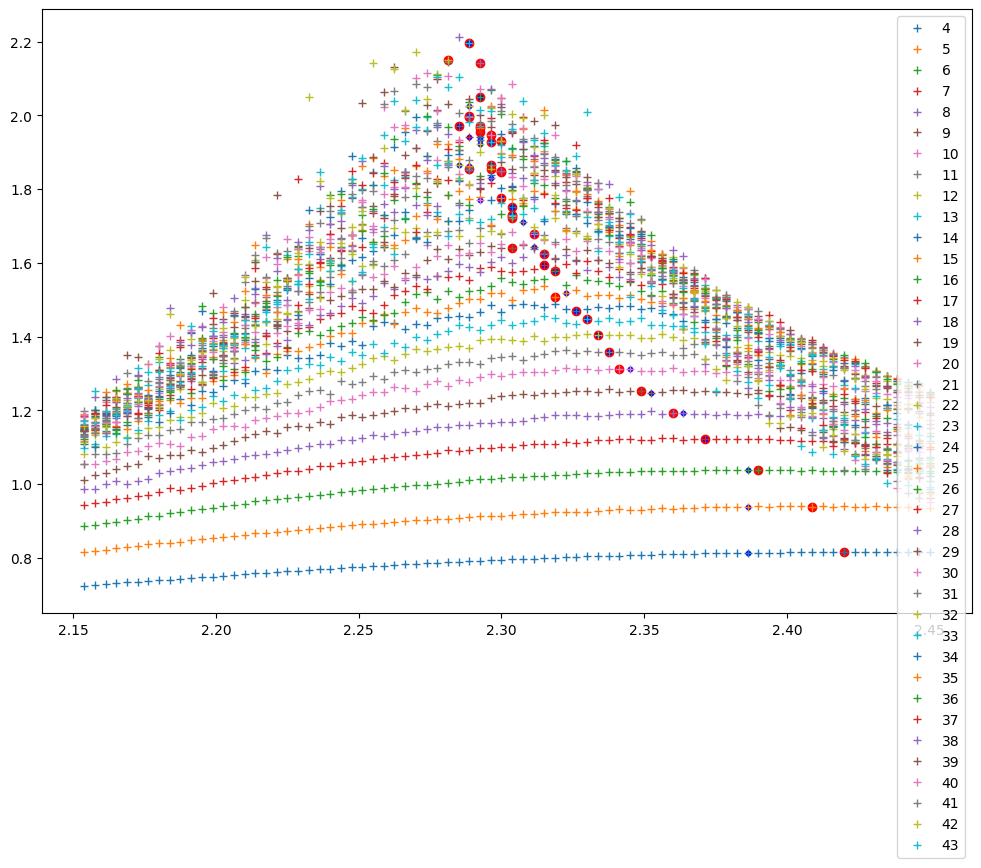

In [92]:
Ns = []
Tcs1 = []
Tcs2 = []
for N in range(4,44):
    df4 = gb.get_group(N)
    plt.plot(df4.temp, df4.C/N**2,"+", label=f"{N}")
    
    pid = find_peak(df4.C, l=5, r=30)
    plt.scatter(df4.temp.iloc[pid], df4.C.iloc[pid]/N**2, c="r")
    
    Tcs1.append(df4.temp.iloc[pid])
    
    pid = find_peak(df4.C, l=10, r=60)
    plt.scatter(df4.temp.iloc[pid], df4.C.iloc[pid]/N**2, c="b", s=10)
    
    Tcs2.append(df4.temp.iloc[pid])
    
    Ns.append(N)
    
plt.legend()

In [68]:
from scipy.optimize import curve_fit

In [97]:
def f(x, Tc, a, nu):
    return Tc + a / (x ** (1/nu))
popt1, popt1_cov = curve_fit(f, Ns, Tcs1)
popt2, popt2_cov = curve_fit(f, Ns, Tcs2)

In [88]:
Tc, a, mu = popt1
print(f"T={Tc:0.3f} a={a:0.3f} mu={mu:0.3f}")
Tc_err, a_err, mu_err = np.sqrt(popt1_cov.diagonal())
print(f"T={Tc_err:0.6f} a={a_err:0.6f} mu={mu_err:0.6f}")


T=2.265 a=0.582 mu=1.148
T=0.003948 a=0.057491 mu=0.086249


In [89]:
Tc, a, mu = popt2
print(f"T={Tc:0.3f} a={a:0.3f} mu={mu:0.3f}")
Tc_err, a_err, mu_err = np.sqrt(popt2_cov.diagonal())
print(f"T={Tc_err:0.6f} a={a_err:0.6f} mu={mu_err:0.6f}")


T=2.255 a=0.492 mu=1.361
T=0.003202 a=0.024313 mu=0.068235


In [83]:
2/np.log(1+np.sqrt(2))

2.269185314213022

In [93]:
f(3, *popt1)

2.488942883647788

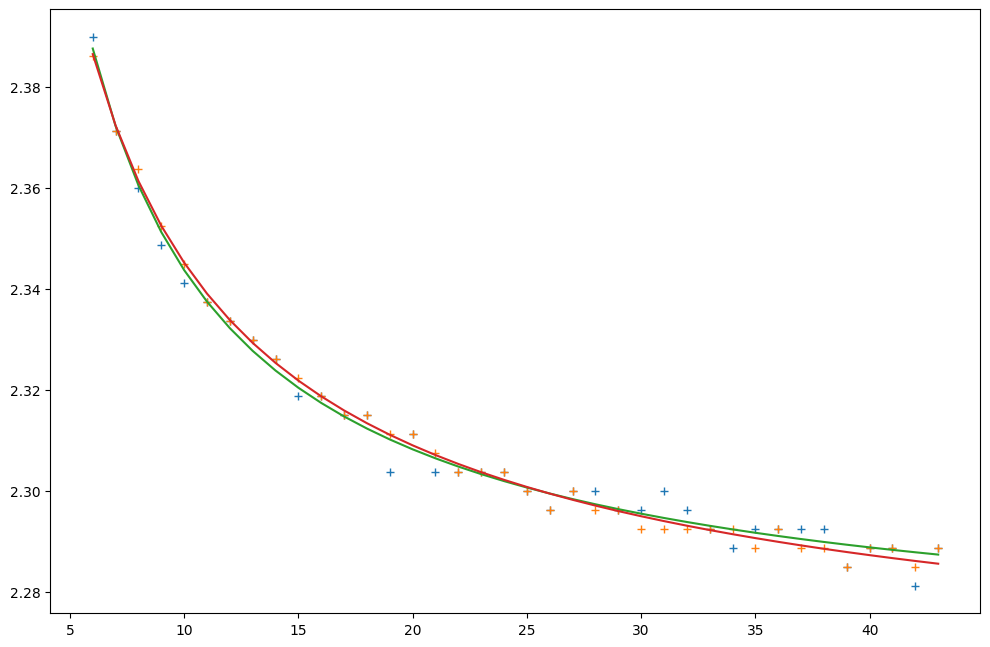

In [80]:
plt.plot(Ns, Tcs1, "+")
plt.plot(Ns, Tcs2, "+")
plt.plot(Ns, f(np.array(Ns), *popt1))
plt.plot(Ns, f(np.array(Ns), *popt2))

In [44]:
pids = []
for w in range(5,30):
    smooth =  np.convolve(df4.C[:], np.ones(w), mode="same")/w
    pids.append(np.argmax(smooth))

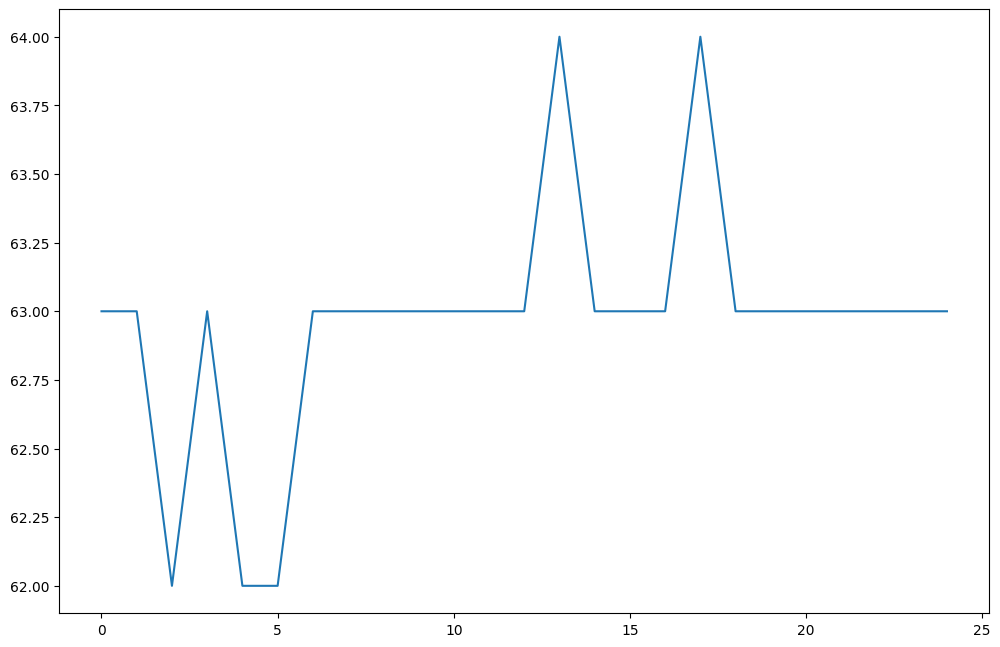

In [45]:
plt.plot(pids)

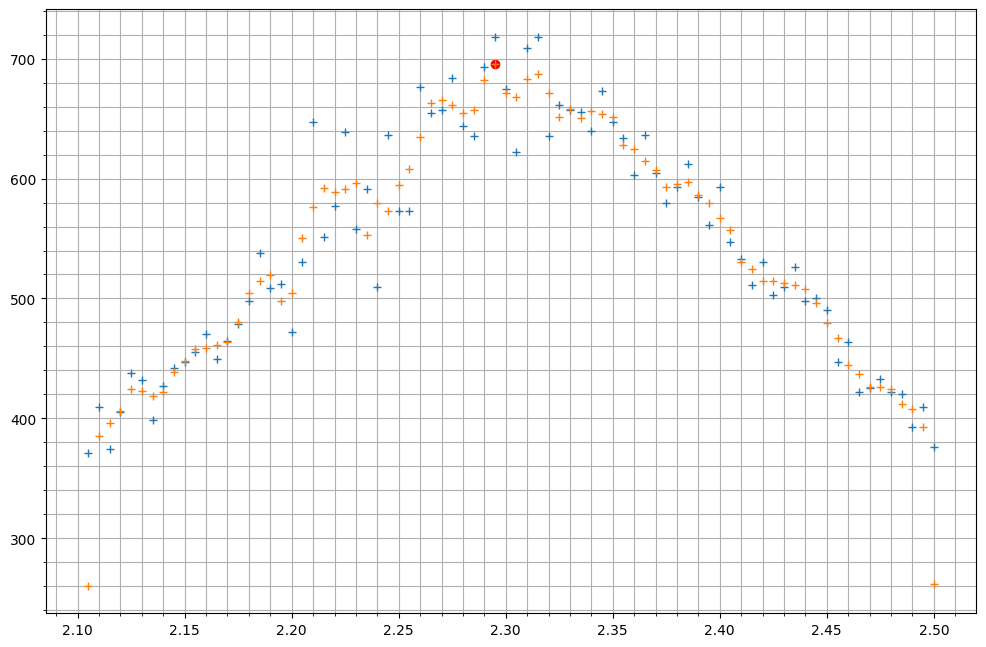

In [70]:
w = 3
smooth =  np.convolve(df.C, np.ones(w), mode="same")/w
peakind = np.argmax(smooth)

plt.plot(df.temp, df.C, "+")
plt.plot(df.temp, smooth, "+")

plt.scatter(df.temp[peakind], smooth[peakind], c="r")
plt.minorticks_on()
plt.grid(which="both")

In [36]:
len(results)

84100

In [ ]:
def findpos(x, start=0):
    def findpos_rec(x, start=0):
        x1 = x[start:]

        mean = np.mean(x1)
        std = np.mean(x1)
        if mean < x[0]:
            mean = - mean
            x = -x
            x1 = -x1
        x2 = x1[x1>=mean]
        mean2 = np.mean(x2)

        #         print(np.where(x>mean2))
        return np.where(x>=mean2)[0][0]
    pos = [0]
    for _ in range(400):
        pos.append(findpos_rec(x, start=pos[-1]))
        if pos[-1]==pos[-2]:
            break
    return pos[-1]

In [38]:
df = pd.DataFrame(results, columns=["T",  "RTM_const", "RTE_const", "RTM_rand", "RTE_rand"])

In [39]:
gb = df.groupby("T")

In [40]:
dfmoments = pd.concat([
gb.mean().add_suffix("_mean"),
gb.std().add_suffix("_std")], axis=1)
dfm = dfmoments[sorted(dfmoments.columns)]

In [42]:
dfm.head()

,RTE_const_mean,RTE_const_std,RTE_rand_mean,RTE_rand_std,RTM_const_mean,RTM_const_std,RTM_rand_mean,RTM_rand_std
T,,,,,,,,
0.045,0.0,0.0,156233.083234,101965.191071,0.0,0.0,108092.258026,97134.962938
0.090,0.0,0.0,161680.202140,117349.768530,0.0,0.0,107544.884661,111024.153631
0.135,0.0,0.0,159884.136742,103570.159579,0.0,0.0,108817.123662,99283.685501
0.180,0.0,0.0,158341.505351,110329.560941,0.0,0.0,105817.594530,106013.854251
0.225,0.0,0.0,158370.552913,102814.365200,0.0,0.0,106921.608799,100432.744776


In [45]:
sprs=2

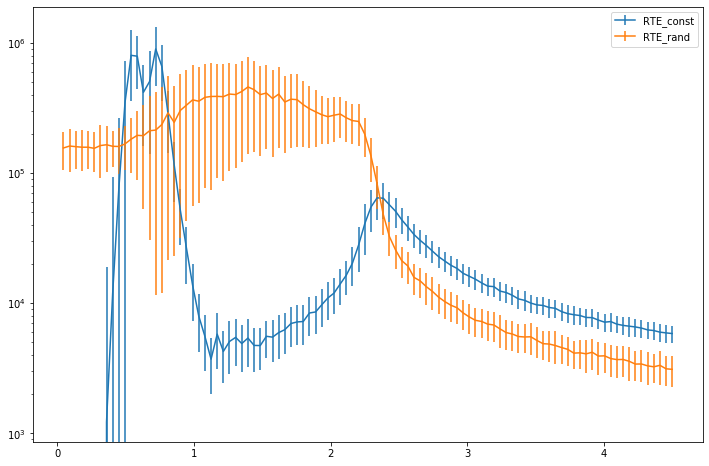

In [49]:
plt.errorbar(dfm.index, dfm.RTE_const_mean, yerr=dfm.RTE_const_std/sprs, label="RTE_const")
plt.errorbar(dfm.index, dfm.RTE_rand_mean, yerr=dfm.RTE_rand_std/sprs, label="RTE_rand")
plt.gca().set_yscale("log")
plt.legend()


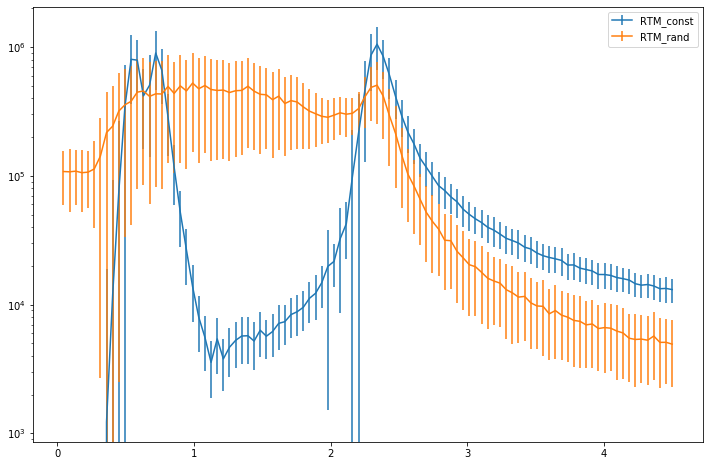

In [48]:
plt.errorbar(dfm.index, dfm.RTM_const_mean, yerr=dfm.RTM_const_std/sprs, label="RTM_const")
plt.errorbar(dfm.index, dfm.RTM_rand_mean, yerr=dfm.RTM_rand_std/sprs, label="RTM_rand")
plt.gca().set_yscale("log")
# plt.ylim(1,3*10**6)
plt.legend()

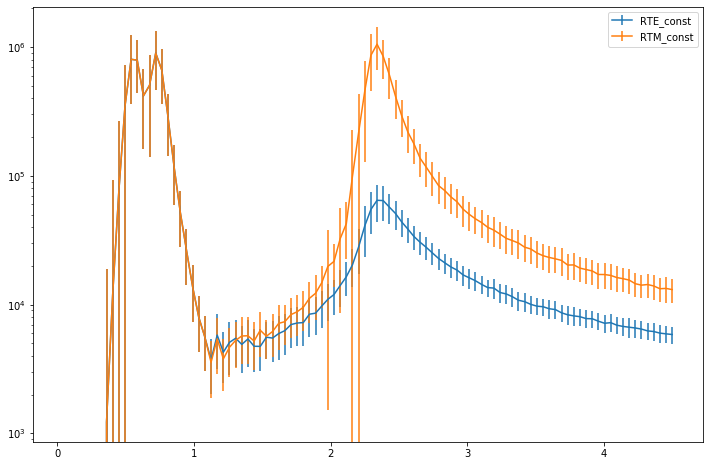

In [50]:
plt.errorbar(dfm.index, dfm.RTE_const_mean, yerr=dfm.RTE_const_std/sprs, label="RTE_const")
plt.errorbar(dfm.index, dfm.RTM_const_mean, yerr=dfm.RTM_const_std/sprs, label="RTM_const")
plt.gca().set_yscale("log")
plt.legend()

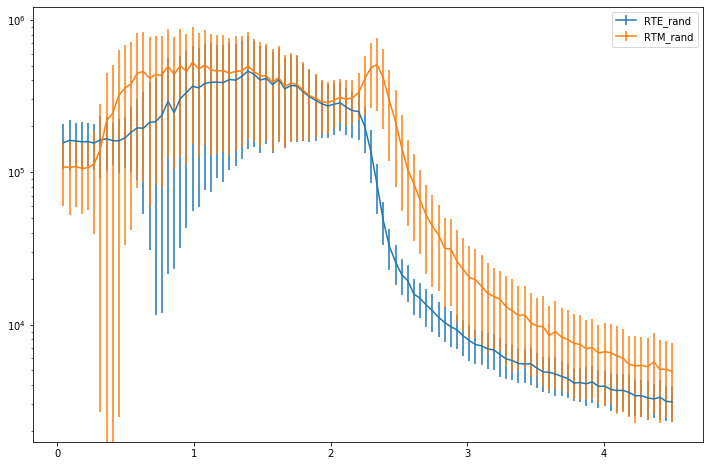

In [51]:
plt.errorbar(dfm.index, dfm.RTE_rand_mean, yerr=dfm.RTE_rand_std/sprs, label="RTE_rand")
plt.errorbar(dfm.index, dfm.RTM_rand_mean, yerr=dfm.RTM_rand_std/sprs, label="RTM_rand")
plt.gca().set_yscale("log")
plt.legend()

/home/ashot/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in power
  """


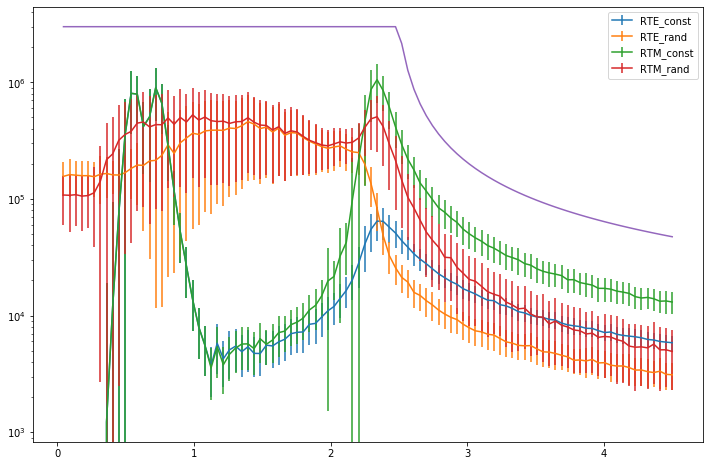

In [104]:
Ts1 = dfm.index.values
steps = np.ones_like(Ts1)*10**5
b=0.08
n=0.1
steps = np.exp(np.log(3*10**6)*(b/(b+Ts1-2.5))**n)
steps[Ts1<2.5] = 3*10**6
steps = steps.astype(int)



plt.errorbar(dfm.index, dfm.RTE_const_mean, yerr=dfm.RTE_const_std/sprs, label="RTE_const")
plt.errorbar(dfm.index, dfm.RTE_rand_mean, yerr=dfm.RTE_rand_std/sprs, label="RTE_rand")
plt.errorbar(dfm.index, dfm.RTM_const_mean, yerr=dfm.RTM_const_std/sprs, label="RTM_const")
plt.errorbar(dfm.index, dfm.RTM_rand_mean, yerr=dfm.RTM_rand_std/sprs, label="RTM_rand")
plt.gca().set_yscale("log")
# plt.xlim(2.5, 4.5)
# plt.ylim(0, 400000)
xs = dfm.index
plt.plot(xs, steps)
# plt.plot(xs, 400000 * np.exp((2.5/xs)))

plt.legend()


In [95]:
a,b = np.polyfit(x,y**-1, 1)

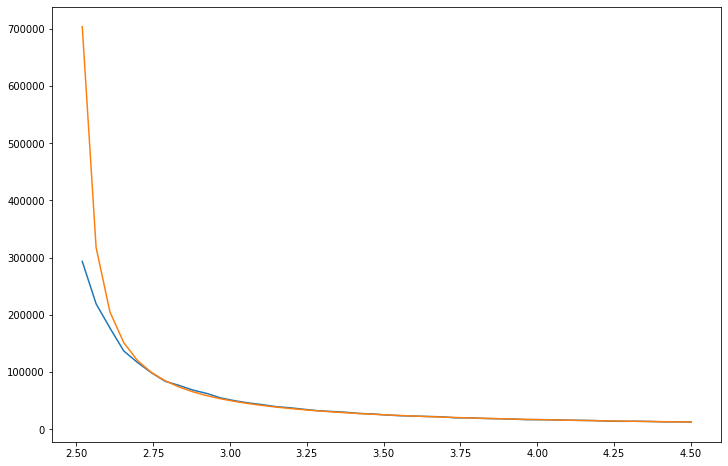

In [97]:
# plt.plot(dfm.index[dfm.index>2.5], dfm.RTM_const_mean[dfm.index>2.5]**-1)
x, y = dfm.index[dfm.index>2.5], dfm.RTM_const_mean[dfm.index>2.5]
# plt.plot(np.log(x),1/np.log(y))
# plt.plot(np.exp(-1/x),y**-1)
plt.plot(x, y)
plt.plot(x, 1/(a*x+b))
# plt.plot(dfm.index[dfm.index>2.5], 1/(a*dfm.index[dfm.index>2.5]+b))
# plt.xlim(2.5, 4.5)
# plt.ylim(0, 400000)

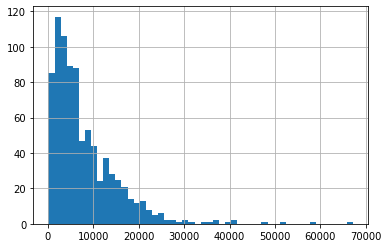

In [36]:
gb.get_group(1.035).RTM_const.hist(bins=50)

In [29]:
Mss_rand  = []
Mss_const = []
Ess_rand  = []
Ess_const = []
T = 0.01
N,M = 1,1000
steps = 1_000_000

for _ in tqdm(range(10)):
    SEED = np.random.randint(100000000)
    _,_,Ms, Es, engine = to_run(1, steps, T=T, N=N, M=M, freq=max(1,steps//10**4), bc=-1,
                            SEED=SEED, return_engine=True, 
                            init="random")
    Mss_rand.append(Ms)
    Ess_rand.append(Es)
    
    SEED = np.random.randint(100000000)
    _,_,Ms, Es, engine = to_run(1, steps, T=T, N=N,M=M, freq=max(1,steps//10**4), bc=-1,
                            SEED=SEED, return_engine=True, 
                            init="constant")
    Mss_const.append(Ms)
    Ess_const.append(Es)
    

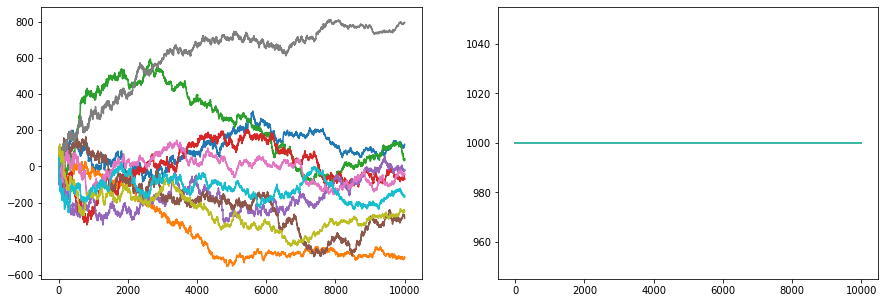

In [30]:
till=-1#1000
plt.figure(figsize=(15,5))
plt.subplot(121)
plt.plot(np.array(Mss_rand).T[:till]);
plt.subplot(122)
plt.plot(np.array(Mss_const).T[:till]);

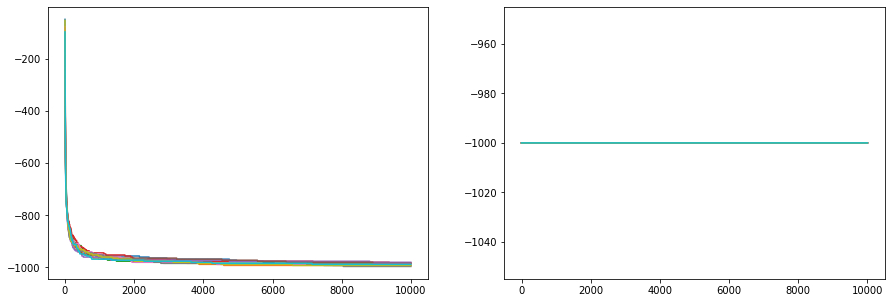

In [31]:
till=-1#1000
plt.figure(figsize=(15,5))
plt.subplot(121)
plt.plot(np.array(Ess_rand).T[:till]);
plt.subplot(122)
plt.plot(np.array(Ess_const).T[:till]);

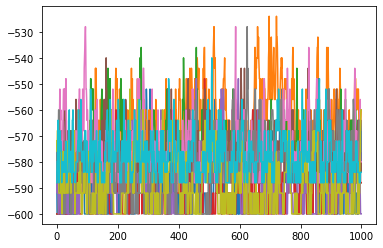

In [25]:
plt.plot(np.array(Ess_const).T[:till][40000:][:1000]);

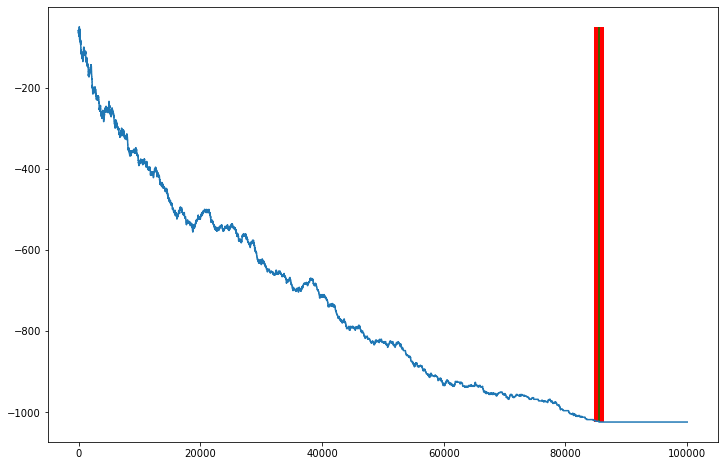

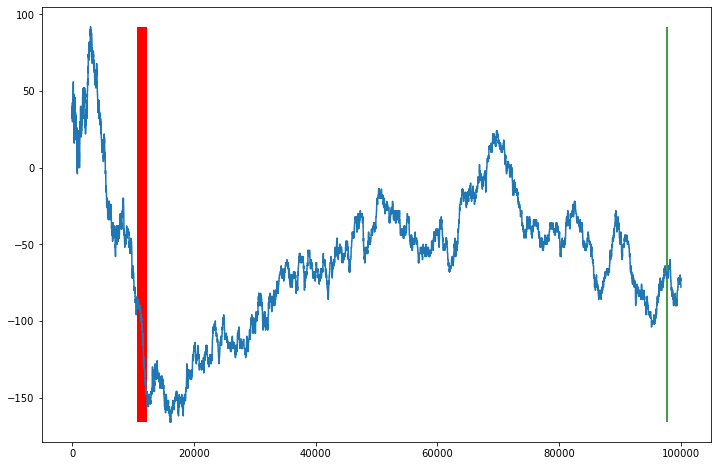

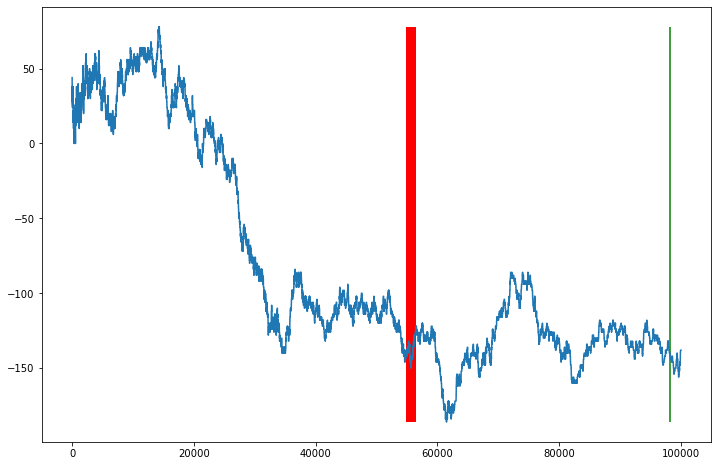

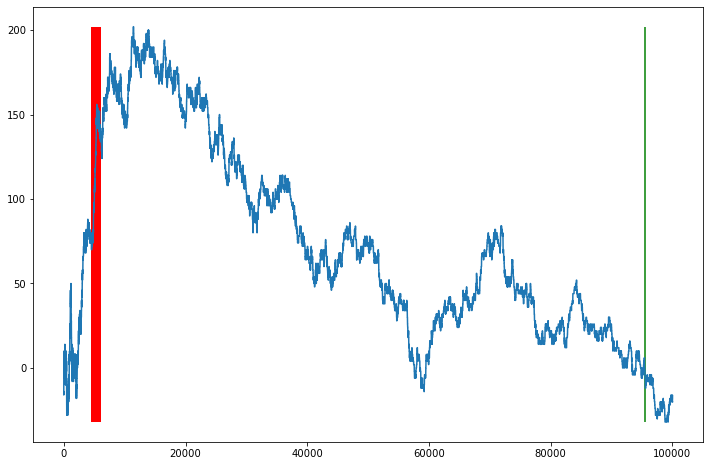

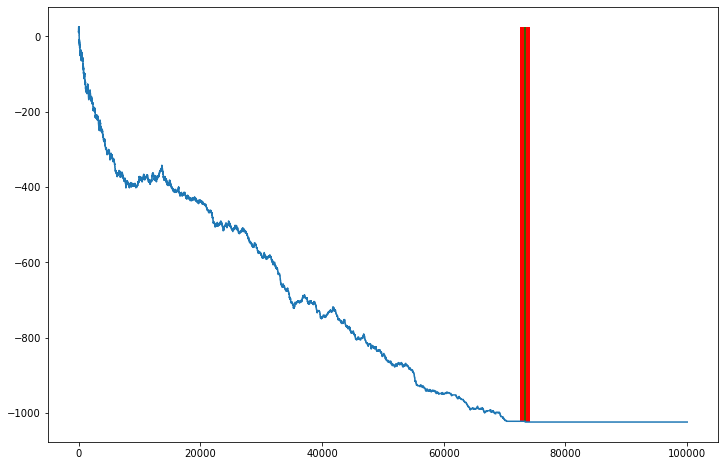

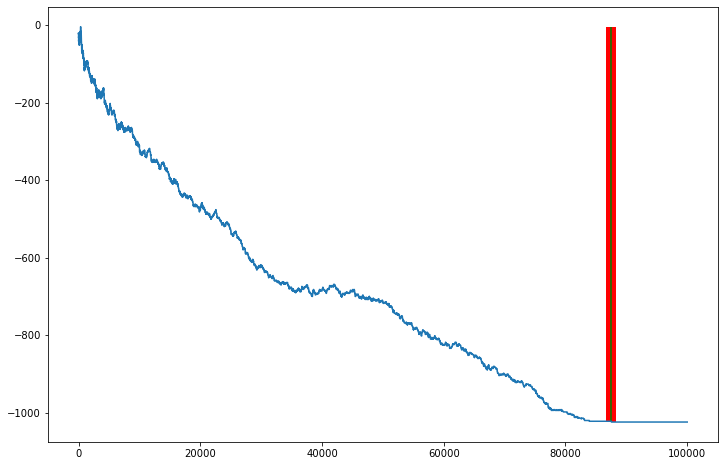

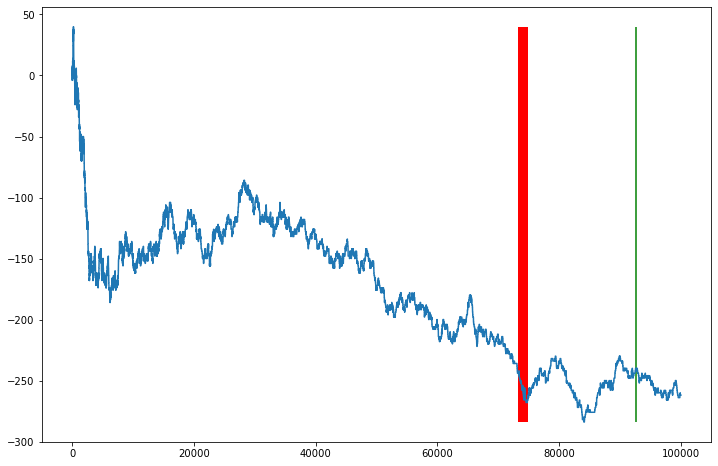

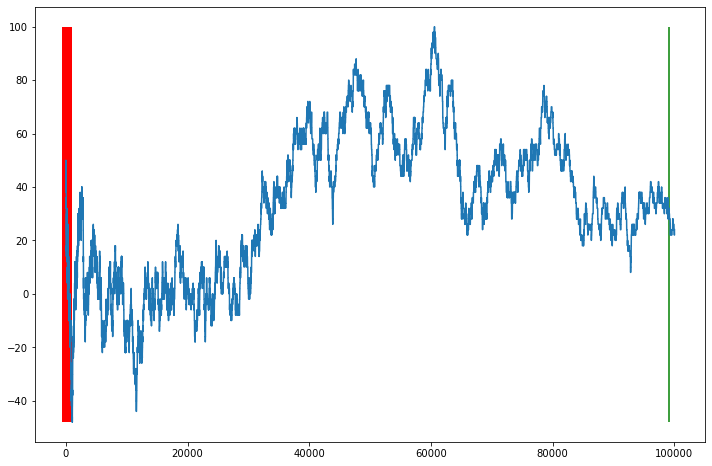

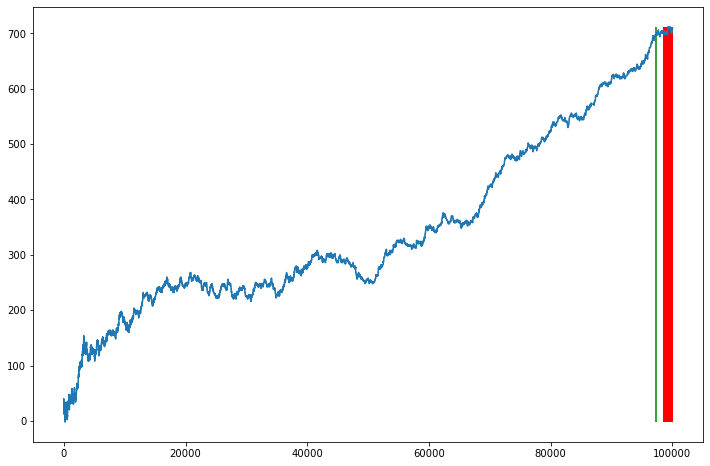

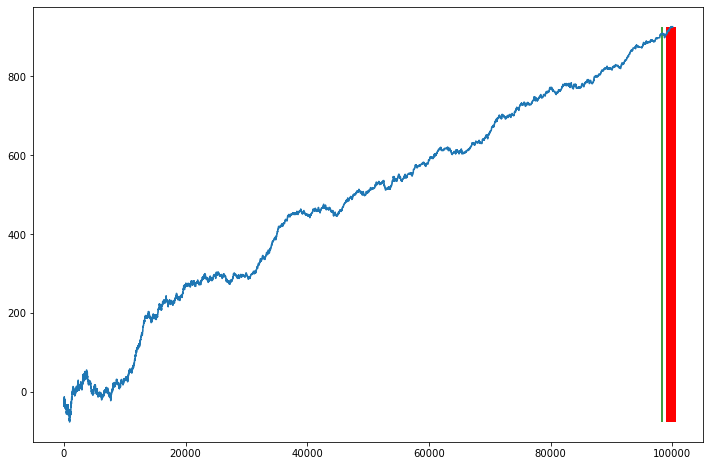

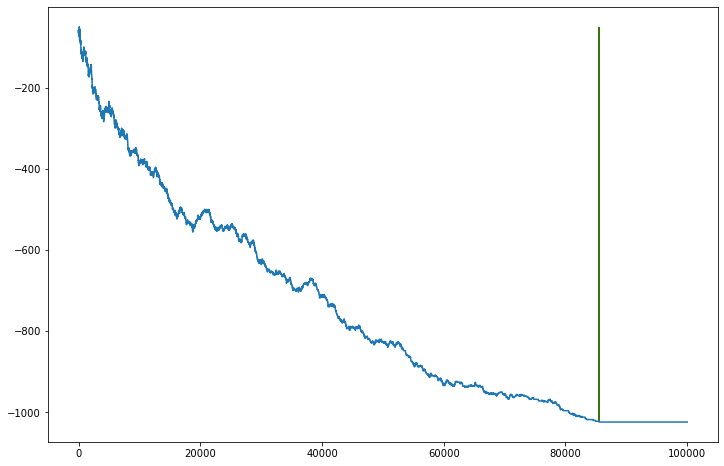

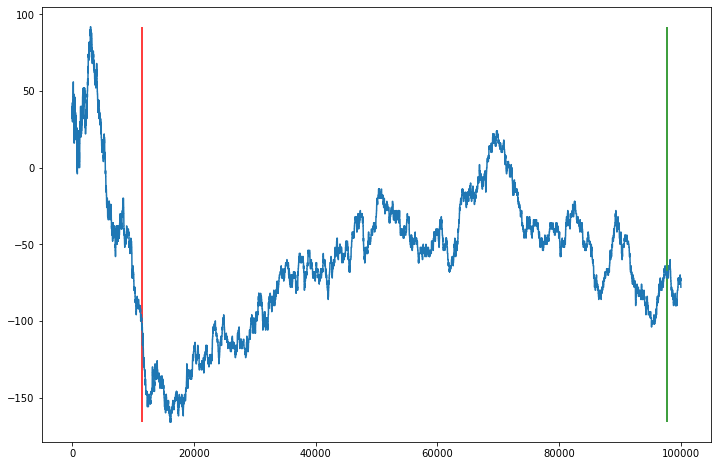

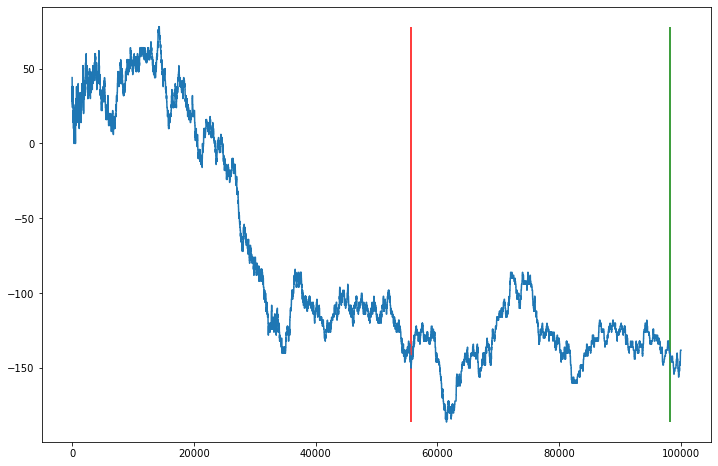

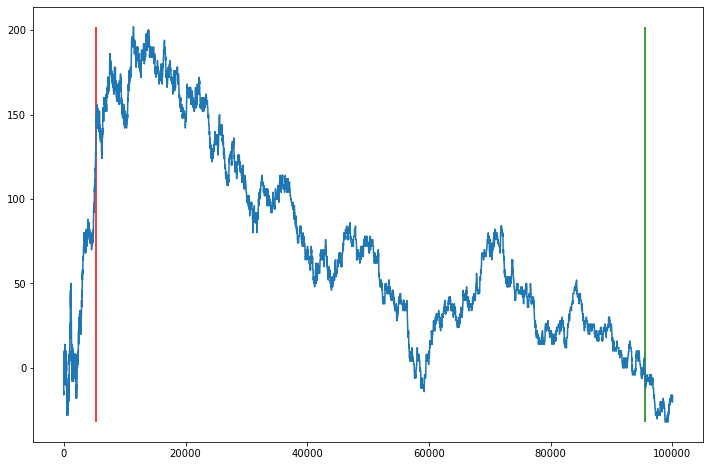

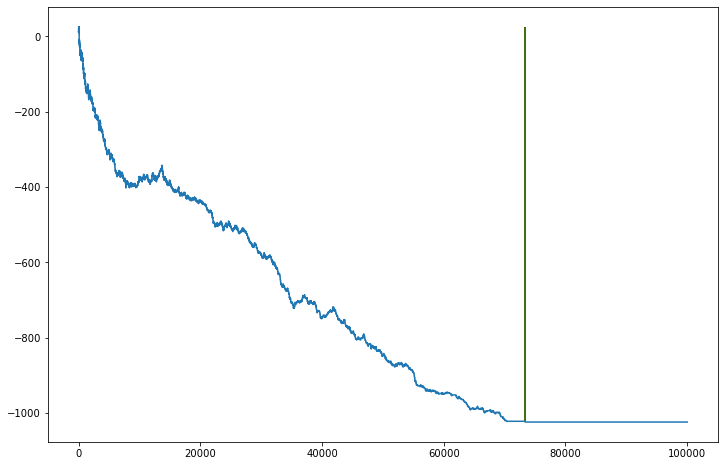

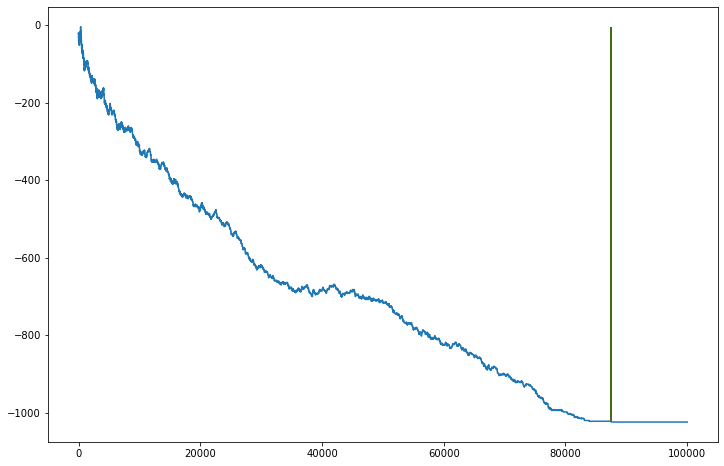

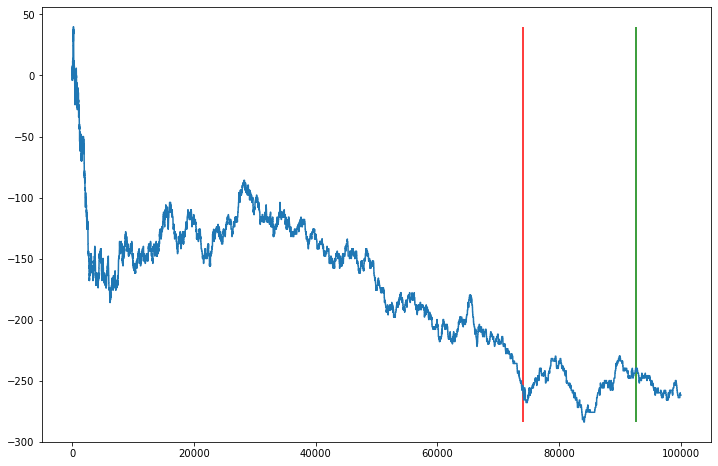

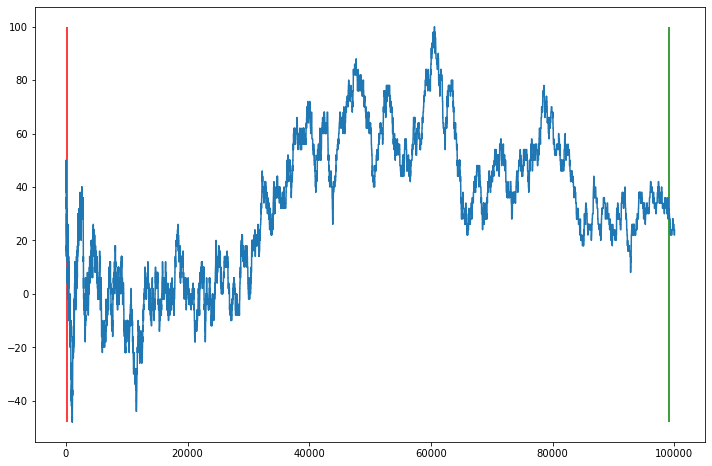

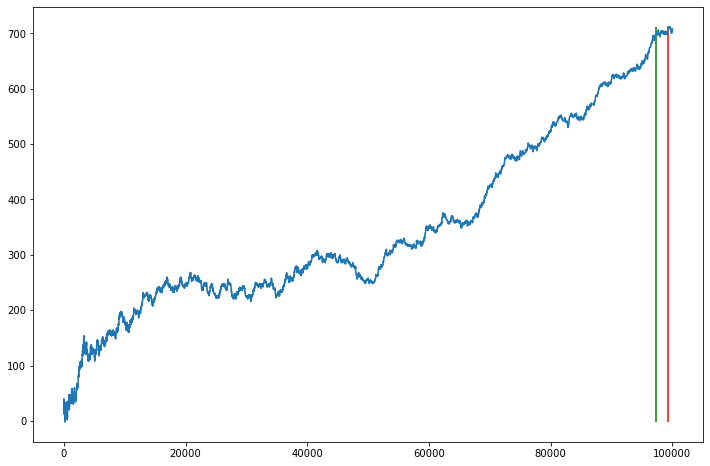

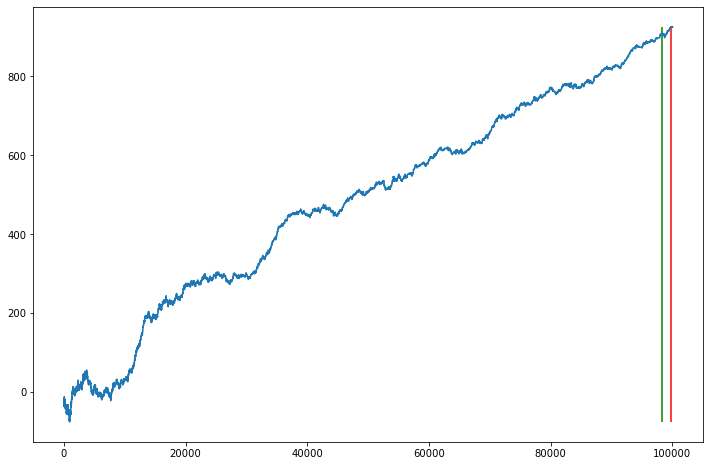

In [163]:
for Ms, Es in zip(Mss_rand, Ess_rand):
    plt.figure()
    plt.plot(Ms)
    pos = findpos(Ms)
    plt.vlines(x=pos, ymax=Ms.max(), ymin=Ms.min(), color="r", lw=10)
    pos = findpos(Es)
    plt.vlines(x=pos, ymax=Ms.max(), ymin=Ms.min(), color="g")
    
    
for Ms, Es in zip(Mss_rand, Ess_rand):
    plt.figure()
    plt.plot(Ms)
    pos = findpos(Ms)
    plt.vlines(x=pos, ymax=Ms.max(), ymin=Ms.min(), color="r")
    pos = findpos(Es)
    plt.vlines(x=pos, ymax=Ms.max(), ymin=Ms.min(), color="g")

In [103]:
Ms = Mss_rand[4]

In [54]:
Ms = Mss_const[4]

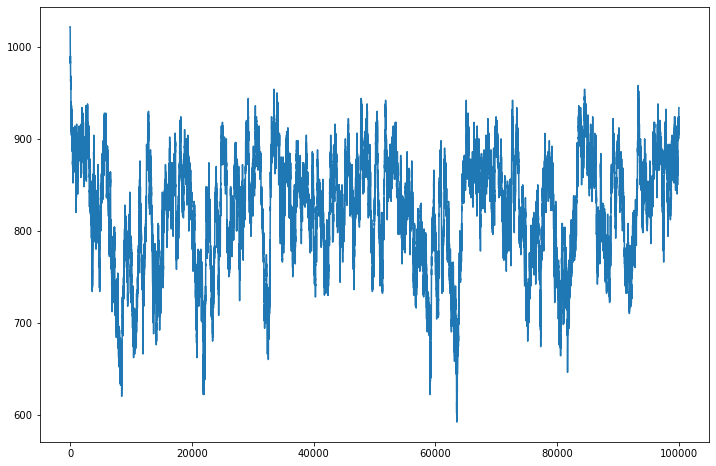

In [59]:
plt.plot(Ms)

In [64]:
np.mean(Ms)

822.91476

In [96]:
findpos(Ms)

(array([ 5531,  5532,  5533, ..., 88733, 88734, 88770], dtype=int64),)
(array([ 5532,  5533,  5534, ..., 88731, 88732, 88733], dtype=int64),)
(array([ 5532,  5533,  5534, ..., 88731, 88732, 88733], dtype=int64),)


5532

In [50]:
pos = [0]
for _ in range(400):
    pos.append(findpos(Ms, start=pos[-1]))
    if pos[-1]==pos[-2]:
        break

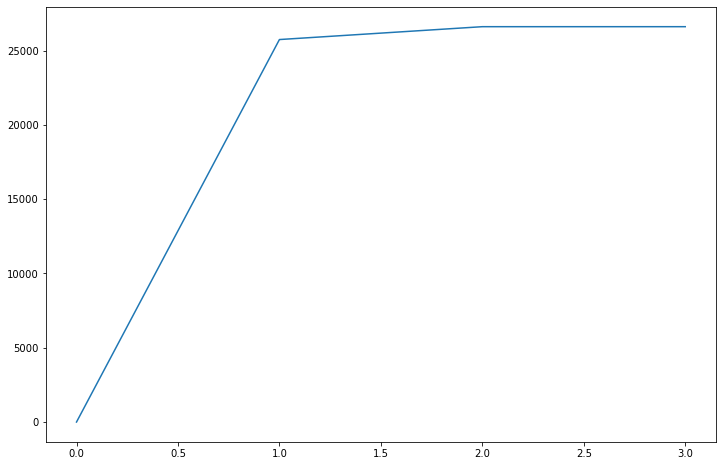

In [51]:
plt.plot(pos)

In [38]:
findpos(Ms, 4524)

4901

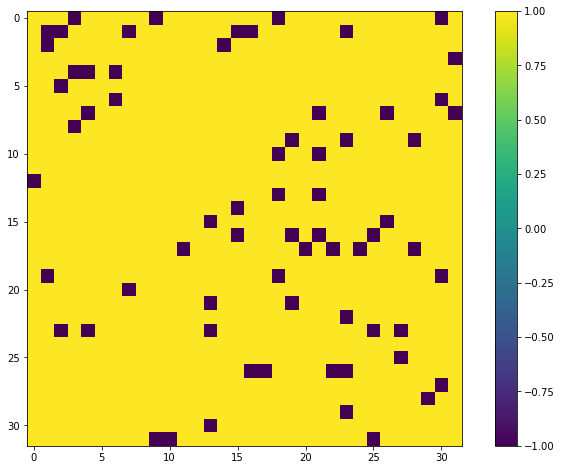

In [18]:
plt.imshow(engine.get_state())
plt.colorbar()